# Prediction Notebook

## Import

In [5]:
import os

import pandas as pd
import numpy as np

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

import joblib
import matplotlib.pyplot as plt

In [3]:
data_path = '../SGNex_A549_directRNA_replicate5_run1/clean_data.csv' # <-- Change the path here to the path of your CSV file.

In [4]:
# Output directory 
output_directory = os.path.dirname(data_path)
output_directory

'../SGNex_A549_directRNA_replicate5_run1'

## Load Prediction Assets

In [6]:
model = load_model('../prediction_assets/rnn_model.keras')

nucleotide_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'PAD': 4}

scaler = joblib.load('../prediction_assets/scaler.joblib')

with open('../prediction_assets/max_sequence_length.txt', 'r') as f:
    max_sequence_length = int(f.read())

In [7]:
if hasattr(scaler, 'mean_'):
    print("Scaler is fitted.")
else:
    print("Scaler is not fitted.")


Scaler is fitted.


## Prediction Functions

In [8]:
# Encode sequences using the loaded nucleotide mapping
def encode_sequence(seq, mapping):
    return [mapping.get(nuc, mapping['PAD']) for nuc in seq]


def predict_new_data(model, scaler, nucleotide_to_int, max_sequence_length, new_data_path):
    # Load new data
    new_df = pd.read_csv(new_data_path)

    # Preprocessing steps
    # Concatenate sequences
    new_df['sequence'] = new_df['Nucleotide 1'] + new_df['Nucleotide 3'].str[-2:]
    new_df['encoded_sequence'] = new_df['sequence'].apply(lambda x: encode_sequence(x, nucleotide_to_int))
    new_df['padded_sequence'] = list(
        pad_sequences(
            new_df['encoded_sequence'],
            maxlen=max_sequence_length,
            padding='post',
            value=nucleotide_to_int['PAD']
        )
    )
    exclude_cols = [
        'Transcript ID', 'Position',
        'Nucleotide 1', 'Nucleotide 2', 'Nucleotide 3',
        'sequence', 'encoded_sequence', 'padded_sequence'
    ]
    numerical_cols = [col for col in new_df.columns if col not in exclude_cols]
    X_seq_new = np.stack(new_df['padded_sequence'].values)
    X_num_new = new_df[numerical_cols].values

    # Transform numerical features using the loaded, fitted scaler
    X_num_new = scaler.transform(X_num_new)

    # Make predictions
    y_pred_proba = model.predict([X_seq_new, X_num_new]).ravel()
    y_pred_class = (y_pred_proba >= 0.5).astype(int)
    new_df['Predicted Probability'] = y_pred_proba
    new_df['Predicted Label'] = y_pred_class

    return new_df


## Running the Prediction

In [9]:
# Usage
predictions = predict_new_data(
    model=model,
    scaler=scaler,
    nucleotide_to_int=nucleotide_to_int,
    max_sequence_length=max_sequence_length,
    new_data_path=data_path
)

31530/31530 [==============================] - 119s 4ms/step


## Results

In [10]:
# Save or inspect the results
print(predictions.head())

     Transcript ID  Position Nucleotide 1 Nucleotide 2 Nucleotide 3  \
0  ENST00000418539       108        GAGAC        AGACC        GACCC   
1  ENST00000418539       139        AAAAC        AAACA        AACAA   
2  ENST00000383898        75        ATGAC        TGACA        GACAC   
3  ENST00000610460        78        AGGAC        GGACA        GACAC   
4  ENST00000619779        78        AGGAC        GGACA        GACAC   

   N1 Length Avg  N1 Length Median  N1 Length Min  N1 Length Max  N1 SD Avg  \
0       0.003320          0.003320       0.003320       0.003320    4.27800   
1       0.007970          0.007970       0.007970       0.007970    3.11500   
2       0.011290          0.011290       0.011290       0.011290    5.47500   
3       0.018260          0.018260       0.018260       0.018260    5.55000   
4       0.008844          0.008844       0.008844       0.008844    4.83954   

   ...  N3 SD Max  N3 Mean Avg  N3 Mean Median  N3 Mean Min  N3 Mean Max  \
0  ...    5.33200     

In [11]:
# Get counts of each predicted label
predicted_label_counts = predictions['Predicted Label'].value_counts()
print(predicted_label_counts)

Predicted Label
0    944907
1     64026
Name: count, dtype: int64


### Visualisations

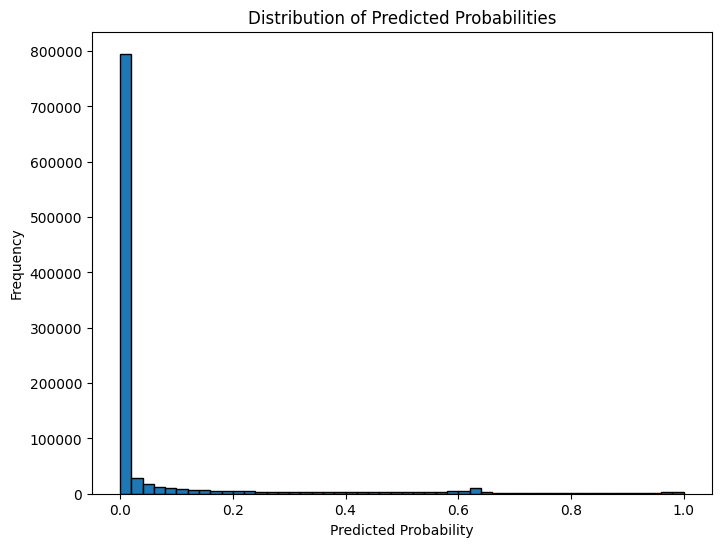

In [20]:
plt.figure(figsize=(8,6))
plt.hist(predictions['Predicted Probability'], bins=50, edgecolor='k')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()


### Label Distribution

In [13]:
# Predicted label counts
label_counts = predictions['Predicted Label'].value_counts()
print("Predicted Label Counts:")
print(label_counts)

# Percentage of positive predictions
total_predictions = len(predictions)
num_positive = label_counts.get(1, 0)
percentage_positive = (num_positive / total_predictions) * 100
print(f"Percentage of instances predicted as positive: {percentage_positive:.2f}%")


Predicted Label Counts:
Predicted Label
0    944907
1     64026
Name: count, dtype: int64
Percentage of instances predicted as positive: 6.35%


## Export Results

In [15]:
final_df = predictions[['Transcript ID', 'Position', 'Predicted Probability', 'Predicted Label']].copy()
final_df.rename(columns={"Transcript ID":"transcript_id", 
                            "Position":"transcript_position", 
                            "Predicted Probability":"score",
                            "Predicted Label":"label"}, inplace=True)

final_df.drop('label', axis=1, inplace=True) ## Uncomment this line to remove the label column.

output_path = os.path.join(output_directory, 'pred_results.csv')

In [16]:
final_df.to_csv(output_path, index=False)